
Spectrometer
============

A spectrometer can be used to measure the spectral response of a system. A probe is pointed at the light source and the sample feeds through to the internal optical bench, which typically comprises routing mirrors, a prism or diffraction grating to separate the sample into its constituent wavelength coponents, and a sensor.  

<img src="../../img/jaz.png" alt="OceanOptics JAZ spectrometer" width=300>

Our JAZ spectrometer has a 16-bit CCD sensor with 2048 pixels and reports wavelengths from 330-1030 nm. The raw spectrum is reported in *counts*, a unit of measurement relating to the number of photons hitting the sensor during the integration period.


Obtaining measurements
----------------------

### `python-seabreeze`

A good alternative to OceanOptics software is the `python-seabreeze` [library](https://python-seabreeze.readthedocs.io/en/latest/#), which enables connection to Ocean Optics spectrometers from Python and provides good functionality.

`pip install seabreeze`

Here's a nice clean way to obtain and visualise a sample using seabreeze.


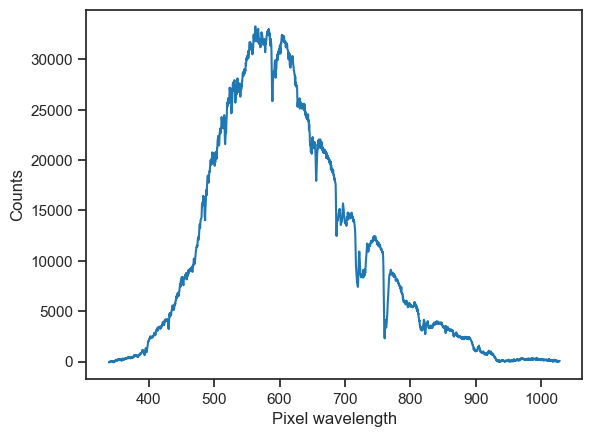

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from seabreeze import spectrometers


sns.set_style('ticks')
sns.set_context('notebook')

try:
    # Connect to spectrometer
    oo = spectrometers.Spectrometer.from_serial_number('JAZA1505')
    
    # Set integration time
    oo.integration_time_micros(1e5)  # 1 s
    
    # Get reported wavelengths
    wls = oo.wavelengths()
    
    # Obtain pixel intensities
    counts = oo.intensities(
        correct_dark_counts=True, 
        correct_nonlinearity=True
    )
    
    # Visualise
    plt.plot(wls, counts)
    plt.xlabel('Pixel wavelength')
    plt.ylabel('Counts')
    
except Exception as e:
    raise e
    
finally:
    oo.close()
        

### `pyplr.oceanops.OceanOptics`

This is my own extension to the `seabreeze.spectrometer.Spectrometers` class. It includes a sampling method with additional features like automatically adapting the integration time of a measurement to hit 80-90% maximum pixel saturation (where the sensor is most linear), averageing a number of scans, and boxcar smoothing.

`pip install pyplr`

It works in the same way and has all the same functionality, but there is a new `.sample(...)` method with some extra options.

> Obtaining sample...
	> Integration time: 0.001 seconds
	> Maximum reported value: 417
	> Integration time: 0.133428 seconds
	> Maximum reported value: 42002
	> Integration time: 0.176954 seconds
	> Maximum reported value: 54984
> Computing average of 3 scans
> Applying boxcar average (boxcar_width = 3)


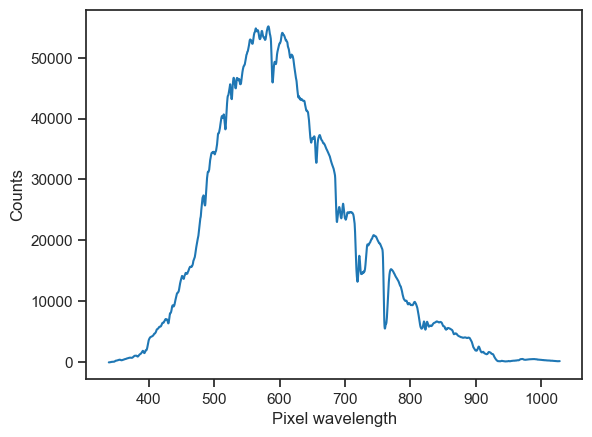

In [4]:
from pyplr import oceanops


try:
    # Connect to spectrometer
    oo = oceanops.OceanOptics.from_serial_number('JAZA1505')
    
    # Obtain sample
    counts, info = oo.sample(
        correct_dark_counts=True,
        correct_nonlinearity=True,
        integration_time=None,  # Optimize integration time
        scans_to_average=3,  # Average of three scans
        boxcar_width=3,  # Boxcar smoothing
        sample_id='daylight_reflected_off_a_wall'
    )
    
    # Visualise
    counts.plot(xlabel='Pixel wavelength', ylabel='Counts')

except KeyboardInterrupt:
    print('> Measurement terminated  by user')

finally:
    oo.close()


Instead of returning `np.array`, the `.sample(...)` method returns `pd.Series` and a Python dictionary with information about the sample. 

In [5]:
counts

339.117812     -64.931663
339.496633     -64.931663
339.875426     -64.931663
340.254190     -64.931663
340.632925     -52.855527
                  ...    
1027.022825    137.802164
1027.304744    140.275895
1027.586598    140.275895
1027.868385    140.275895
1028.150106    140.275895
Length: 2048, dtype: float64

In [6]:
info

{'board_temp': 'NA',
 'micro_temp': 'NA',
 'integration_time': 179273,
 'scans_everaged': 3,
 'boxcar_width': 3,
 'max_reported': 55144.67918786054,
 'upper_bound': 58981.5,
 'lower_bound': 52428.0,
 'model': 'JAZ',
 'serial': 'JAZA1505',
 'obtained': '2022-09-12 11:17:21.831779',
 'sample_id': 'daylight_reflected_off_a_wall'}

Also, if you don't specify an integration time, it will be adjusted until the maximum reported value is within 80-90% of pixel resolution, where linearity is best (as above). 

Signal-to-noise ratio may also be improved with scan averaging and boxcar smoothing, but be warned! The former increases overall sampling time and the latter comes at the expense of optical resolution and may wash out spectral features if a high value is used. A good rule of thumb is to use low values (e.g., 1-3).


> Obtaining sample...
	> Integration time: 0.01 seconds
	> Maximum reported value: 3691
> Applying boxcar average (boxcar_width = 0)
> Obtaining sample...
	> Integration time: 0.01 seconds
	> Maximum reported value: 3701
> Computing average of 2 scans
> Applying boxcar average (boxcar_width = 0)
> Obtaining sample...
	> Integration time: 0.01 seconds
	> Maximum reported value: 3652
> Computing average of 5 scans
> Applying boxcar average (boxcar_width = 0)
> Obtaining sample...
	> Integration time: 0.01 seconds
	> Maximum reported value: 3641
> Computing average of 10 scans
> Applying boxcar average (boxcar_width = 0)
> Obtaining sample...
	> Integration time: 0.01 seconds
	> Maximum reported value: 3498
> Computing average of 50 scans
> Applying boxcar average (boxcar_width = 0)
> Obtaining sample...
	> Integration time: 0.01 seconds
	> Maximum reported value: 3512
> Computing average of 100 scans
> Applying boxcar average (boxcar_width = 0)
> Obtaining sample...
	> Integration time: 

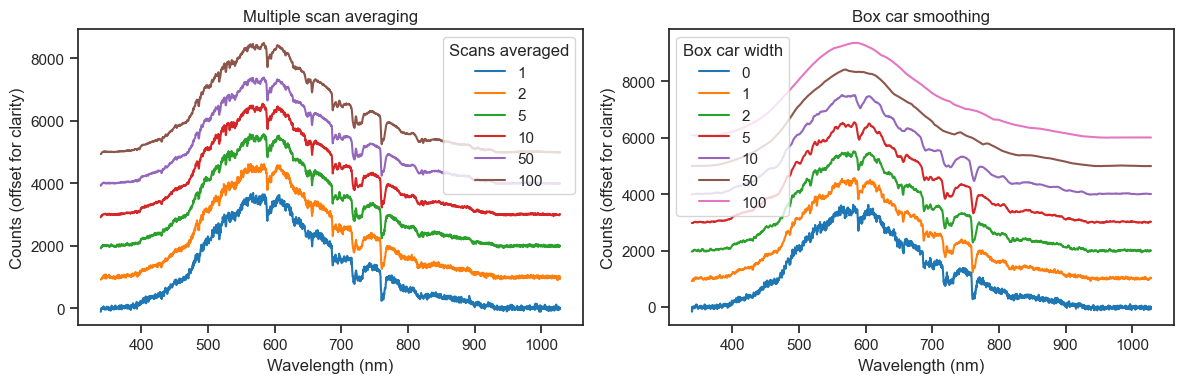

In [8]:
try:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    oo = oceanops.OceanOptics.from_serial_number('JAZA1505')
    
    for i, scans_to_average in enumerate([1, 2, 5, 10, 50, 100]):
        
        counts, info = oo.sample(
            correct_dark_counts=True,
            correct_nonlinearity=True,
            integration_time=1e4,
            scans_to_average=scans_to_average
        )
        ax1.plot(counts+(i*1000), label=scans_to_average)
    
    ax1.set_title('Multiple scan averaging')
    ax1.legend(title='Scans averaged')

    for i, boxcar_width in enumerate([0, 1, 2, 5, 10, 50, 100]):
        
        counts, info = oo.sample(
            correct_dark_counts=True,
            correct_nonlinearity=True,
            integration_time=1e4,
            boxcar_width=boxcar_width
        )
        
        ax2.plot(counts+(i*1000), label=boxcar_width)
    
    ax2.set_title('Box car smoothing')
    ax2.legend(title='Box car width')

    for ax in (ax1, ax2):
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Counts (offset for clarity)')
    
    plt.tight_layout()

except KeyboardInterrupt:
    print('> Measurement terminated  by user')

finally:
    oo.close()

I've found my seabreeze extension very useful, especially when automating measurements (e.g., when measuring the spectral response of a multiprimary system).


Wavelength calibration
----------------------

The pixels on the spectrometer CCD sensor are aligned to different wavelengths.

[According to Ocean Optics](https://www.oceaninsight.com/support/faqs/calibration/), the relationship between pixel and wavelength is described by a third-order polynomial:

\begin{equation}
\lambda_p = I + C_1 p + C_2 p^2 + C_3 p^3 
\end{equation}

Where:

  - $\lambda$ = wavelength of pixel $p$
  - $I$ = wavelength of pixel 0
  - $C1$ = first coefficient (nm/pixel)
  - $C2$ = second coefficient (nm/pixel$^2$)
  - $C3$ = third coefficient (nm/pixel$^3$)
  
The JAZ stores wavelength coefficients from when it was last calibrated, but wavelength calibrations are liable to drift over time due to various factors (e.g., mechanical shock, environmental conditions). 

The ground truth for wavelength calibration is dervied from sampling a light source that produces [spectral lines](https://en.wikipedia.org/wiki/Spectral_line), so we borrowed a [Philips argon lamp](http://www.lamptech.co.uk/Spec%20Sheets/D%20SP%20Philips%20LL%20Ar.htm) from our local physics department. 

<img width=300 src='../../img/jaz_argon_lamp.png'>


Measurement of the lamp produced a spectrum with lots of lines. I consulted the [NIST atomic spectra database](https://physics.nist.gov/PhysRefData/ASD/lines_form.html) to find the known positions of the lines. 

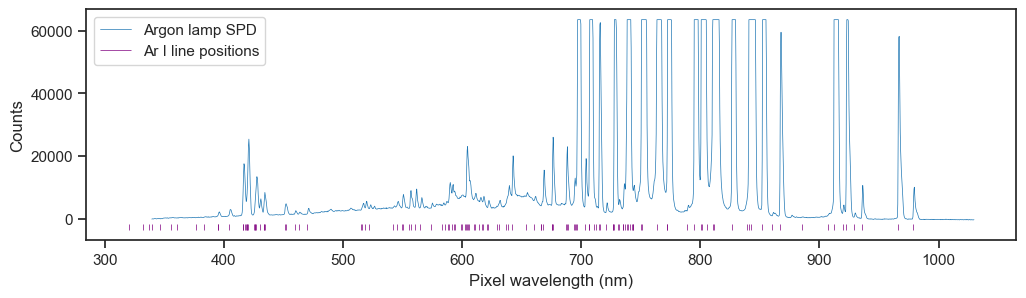

In [15]:
import numpy as np
import pandas as pd


# Load sample and spectral lines
ar_spd = pd.read_csv('../../data/jaz/jaz_Ar_spd.csv', index_col='wl')
ar_lines = pd.read_csv('../../data/jaz/NIST_Ar_1_lines_300_1000.csv')

# Plot spd and line positions
fig, ax = plt.subplots(figsize=(12, 3))
ar_spd.pwr.plot(ax=ax, lw=.5, label='Argon lamp SPD')
ax.vlines(ar_lines['wl'], -3500, -1750, color='purple', lw=.5, label='Ar I line positions')
ax.set(xlabel='Pixel wavelength (nm)',
       ylabel='Counts')
ax.legend();

Many of the lines were not resolved by the spectrometer, presumably due to undersaturation or pixel resolution limitations, but most tallied up with visible peaks. I used a peak-finding algorithm to try and find the corresponding peaks in the spectrum, based on certain criteria.

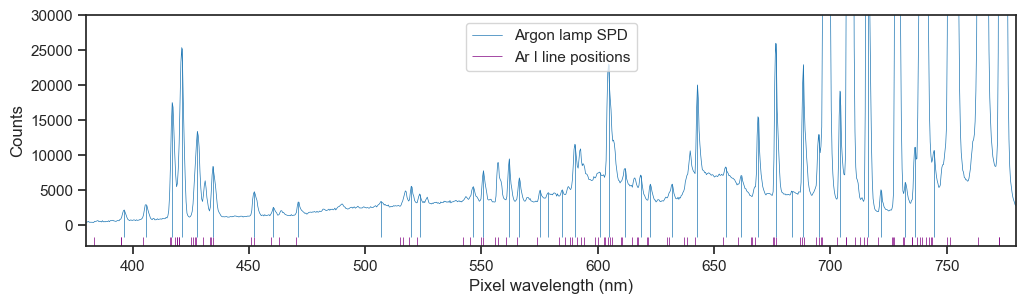

In [16]:
from scipy import signal

# Find peaks
peak_idxs = signal.find_peaks(ar_spd['pwr'], height=1800, prominence=300, threshold=30, distance=10)[0]
peaks = ar_spd.loc[ar_spd.pxl.isin(peak_idxs)].reset_index()
ax.vlines(peaks['wl'], -1750, peaks['pwr'], lw=.5)
ax.set_xlim((380, 780))
ax.set_ylim((-3000, 30000))
ax.legend()
fig

This showed a general pattern of rightward drift of about 1 nm, but the line pairing was not obvious so I zoomed in on a pdf plot and manually paired the detected peaks with the nearest line to the left, if there was one, dropping it otherwise. This led to 44 lines accross the full range of reported wavelengths. 

In [17]:

# True line positions for selected peaks
true_wls = [
    394.8979, 404.4418, 415.859, 419.8317, 426.6286, 433.3561, 
    451.0733, 459.6097, 470.2316, 518.7746, 522.1271, 545.1652,
    549.5874, 560.6733, 565.0704, 573.952, 583.4263, 588.8584,
    599.8999, 603.2127, 610.5635, 617.3096, 621.5938, 630.7657,
    641.6307, 653.8112, 660.4853, 667.7282, 675.2834, 687.1289,
    693.7664, 703.0251, 714.7042, 720.698, 731.1716, 735.3293,
    743.6297, 789.1075, 860.5776, 866.7944, 919.4638, 935.422, 
    965.7786, 978.4503
]

# Remove suspect peaks without a true-line companion
drop_px = [448, 648, 947]
peaks = peaks.loc[~peaks.pxl.isin(drop_px)] 
peaks['true_wl'] = true_wls


Now, to calculate the wavelength coefficients and predict the new values.

In [19]:
# Third order polynomial
poly = np.polyfit(peaks['pxl'], peaks['true_wl'], deg=3)
print('> The wavelength coefficients are:\n')
print(*poly[::-1], sep='\n')
calibrated_wls = np.polyval(poly, ar_spd.pxl)


> The wavelength coefficients are:

338.5374924539017
0.3802367113739599
-1.5959354792685768e-05
-2.507246200675931e-09


These coefficients can be updated in the spectrometer using Ocean Optics software, or the new wavelengths can be applied at a later stage of processing.

Here's the visible portion of the original spectrum plotted against the old and new wavelengths. Note that the true lines match better with the peaks when they are plotted against the calibrated wavelengths. 

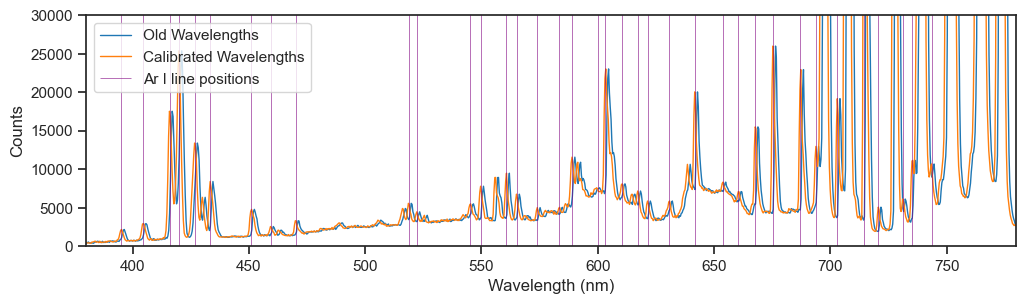

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(ar_spd.index, ar_spd.pwr, lw=1, label='Old Wavelengths')
ax.plot(calibrated_wls, ar_spd.pwr, lw=1, label='Calibrated Wavelengths')
ax.vlines(true_wls, 0, 60000, color='purple', lw=.4, label='Ar I line positions')
ax.set(xlim=(380, 780),
       ylim=(0, 30000),
       xlabel='Wavelength (nm)',
      ylabel='Counts')
ax.legend(loc='upper left');

In the end it was a lot of effort for a small correction, but worth it!


Absolute irradiance calibration
-------------------------------

Absolute irradiance calibration allows for measurements to be reported in energy units, such as $\mu W/cm^2/nm$, which can be preferable to *counts*-based measures. This is achieved by taking a reference measurement of a radiometrically calibrated light source with known power output and then working out, for each pixel, how many microjoules a count represents (i.e., $\mu J/count$ ratio). 

[According to Ocean Optics](https://www.oceaninsight.com/support/faqs/calibration/), with the $\mu J/count$ ratio for each pixel, one can convert to energy units using this forumla:

\begin{equation}
I_p = (S_p - D_p) * C_p / (T * A * dL_p)
\end{equation}

Where:

  - $C_p$ = calibration file, in $\mu J/count$ (specific to the sampling optic)
  - $S_p$ = sample spectrum in count units
  - $D_p$ = dark spectrum in count units (i.e., the electrical noise floor)
  - $T$ = integration time in seconds
  - $A$ = collection area in cm$^2$
  - $dL_p$ = wavelength spread (how many nanometers each pixel represents)

Our NIST-traceable HL-2000-CAL light source is suitable for absolute irradiance calculation. It has a tungsten-halogen bulb with a color temperature of 3100 kelvin, and it came with calibration files expressing its known power output at certain wavelengths in $\mu W/cm^2/nm$, when measured with either a fibre optic probe or cosine corrector (the sampling optic affects the measured power).

It is relatively easy to perform an absolute irradiance calibration with the [Ocean View software](https://www.oceaninsight.com/products/software/acquisition-and-analysis/oceanview/), which is available for a 30-day free trial. 

Turn the light source on and wait for it to reach thermal equilibrium (~15 mins) and then select the *Absolute Irradiance Calibration* option. The software guides you through the process of taking a reference measurement, a dark measurement to compensate for electrical noise in the CCD, uploading the relevant lamp calibration file, and obtaining the $\mu J/count$ pixel calibration file.

<img width=400 src='../../img/jaz_hl_2000_cal.png'>

The calibration output looks like this.

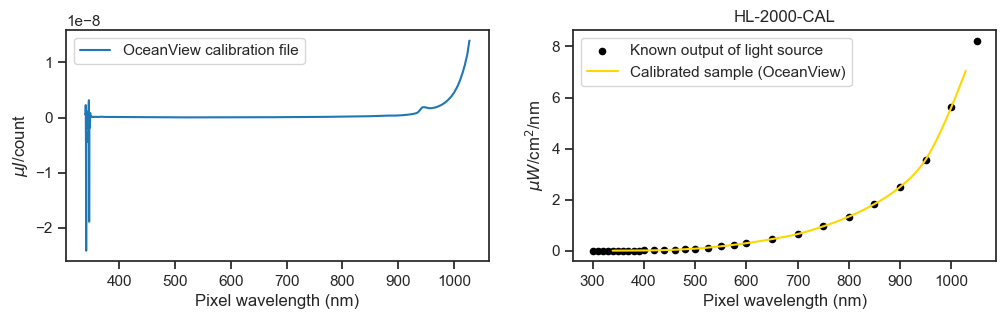

In [21]:
# Load the HL-2000-CAL lamp calibration data for fibre optic probe
lamp_file = pd.read_table('../../data/jaz/030410313_FIB.LMP', header=None)
lamp_file.columns = ['Wavelength', 'uJ/cm2']
lamp_file = lamp_file.squeeze()

# Load the Ocean View calibration output
ocean_view_cal = pd.read_table('../../data/jaz/JAZ_OOIIrrad.cal', skiprows=8).squeeze()
lamp_preview = pd.read_table('../../data/jaz/JAZ_LampIntensityPreview.txt', skiprows=8)
lamp_preview.columns = [s.strip(' ') for s in lamp_preview.columns]
lamp_preview = lamp_preview.set_index('Wavelength').squeeze()

# Visualise
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ocean_view_cal.plot(ax=ax1, ylabel='$\mu J$/count', label='OceanView calibration file')
lamp_file.plot(ax=ax2, x='Wavelength', y='uJ/cm2', kind='scatter', c='k', title='HL-2000-CAL', label='Known output of light source')
lamp_preview.plot(ax=ax2, c='gold', ylabel='$\mu W$/cm$^2$/nm', label='Calibrated sample (OceanView)');

for ax in [ax1, ax2]:
    ax.set(xlabel='Pixel wavelength (nm)')
    ax.legend()


Here's how to perform the irradiance calibration without using OceanView. 

Hit enter to obtain reference measurement: 


> Obtaining sample...
	> Integration time: 0.001 seconds
	> Maximum reported value: 6165
	> Integration time: 0.009035 seconds
	> Maximum reported value: 44892
	> Integration time: 0.011211 seconds
	> Maximum reported value: 54797
> Computing average of 3 scans
> Applying boxcar average (box_car_width = 4)


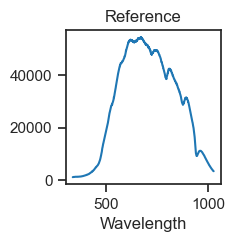

Now block all light and hit enter to obtain dark counts: 


> Obtaining sample...
	> Integration time: 0.011397 seconds
	> Maximum reported value: 1279
> Computing average of 3 scans
> Applying boxcar average (box_car_width = 4)


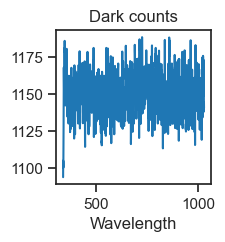

> Closing connection to spectrometer


In [23]:
from scipy import interpolate

from pyplr.oceanops import OceanOptics


try:
    # Connect to JAZ
    oo = OceanOptics.from_serial_number('JAZA1505')

    # Perform reference measurement
    input('Hit enter to obtain reference measurement:')
    reference_counts, reference_info = oo.sample(
        correct_nonlinearity = True,
        correct_dark_counts = False,
        scans_to_average=3,
        box_car_width=4
    )
    reference_counts.plot(figsize=(2, 2), title='Reference')
    plt.show()

    # Perform dark measurement
    input('Now block all light and hit enter to obtain dark counts:')
    dark_counts, dark_info = oo.sample(
        correct_nonlinearity = True,
        correct_dark_counts = False,
        integration_time = reference_info['integration_time'],
        scans_to_average=3,
        box_car_width=4
    )
    dark_counts.plot(figsize=(2, 2), title='Dark counts')
    plt.show()

    # Resample lamp file to pixel wavelengths
    interp_func = interpolate.interp1d(lamp_file['Wavelength'], lamp_file['uJ/cm2'])
    wavelengths = reference_counts.index
    resampled_lamp_data = interp_func(wavelengths)     

    # Calculate scaling parameters
    integration_time = reference_info['integration_time'] / 1e6  # Microseconds to seconds
    fibre_diameter = 400 / 1e4  # Microns to cm
    collection_area = np.pi * (fibre_diameter/2) ** 2  # cm2
    wavelength_spread = np.hstack(  # How many nanometers each pixel represents
        [(wavelengths[1] - wavelengths[0]),
         (wavelengths[2:] - wavelengths[:-2]) / 2,
         (wavelengths[-1] - wavelengths[-2])
        ]
    )

    # Make the calibration file. To do this we need to adapt the 
    # formula slightly, dividing the resampled lamp data by the
    # reference measurement (instead of multiplying the reference
    # measurement by the calibration file). 
    calibration_file = (
        resampled_lamp_data
        / ((reference_counts - dark_counts)
           / (integration_time
              * collection_area
              * wavelength_spread)
          )
    )

except KeyboardInterrupt:
    print('> Calibration terminated by user')

except Exception as e:
    print('> Something else went wrong')
    raise e

finally:
    oo.close()
    print('> Closing connection to spectrometer')



Let's compare the new calibration with the one from Ocean View and focus on the visible wavelengths.

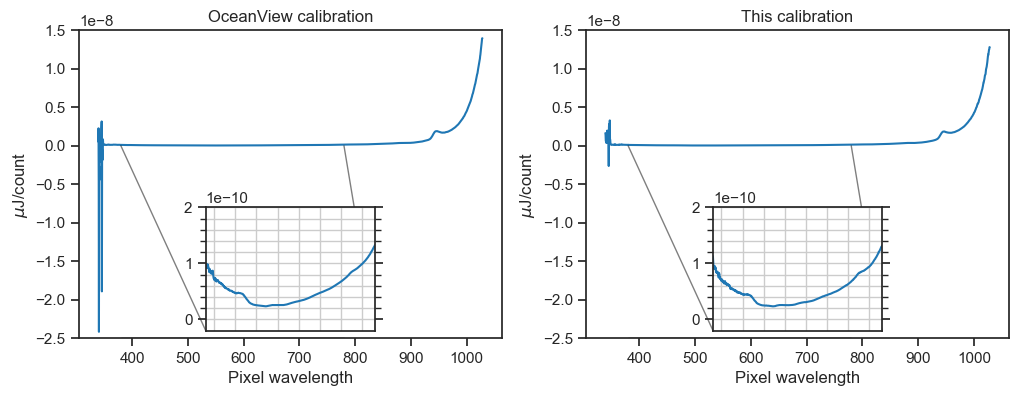

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import (
    mark_inset, 
    inset_axes
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ocean_view_cal.plot(ax=ax1, title='OceanView calibration', legend=False)

axins1 = inset_axes(ax1, '40%', '40%', loc='lower center')
ocean_view_cal.plot(ax=axins1, legend=False)

calibration_file.plot(ax=ax2, title='This calibration')
axins2 = inset_axes(ax2, '40%', '40%', loc='lower center')
calibration_file.plot(ax=axins2, legend=False, xlabel='')

for axins in [axins1, axins2]:
    axins.set_xlim(380, 780)
    axins.set_ylim(-.002e-8, .02e-8)
    axins.set_xticklabels([])
    axins.minorticks_on()
    axins.tick_params(which='both', bottom=False, right=True)
    axins.grid(True, 'both')


for ax, axins in zip([ax1, ax2], [axins1, axins2]):
    ax.set_ylim((-2.5e-8, 1.5e-8))
    ax.set_ylabel('$\mu$J/count')
    ax.set_xlabel('Pixel wavelength')

    ax.indicate_inset_zoom(
        axins, 
        edgecolor="black",
        transform=ax.get_xaxis_transform()
    )


The insets show, according to each calibration file, the $\mu J/count$ ratio for all pixels that represent visible wavelengths. Pretty much the same!

The final test... apply the original formula to the reference measurement using each calibration file. 

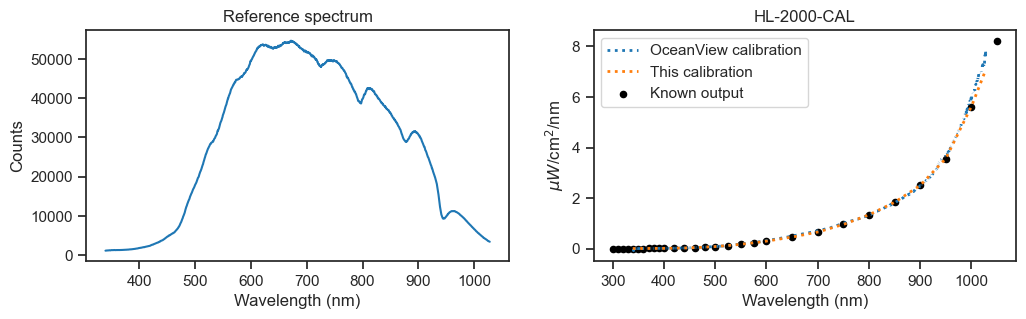

In [25]:
# This calibration
this_calibration_spectrum = (
    (reference_counts - dark_counts)
    * (calibration_file
       / (integration_time
          * collection_area
          * wavelength_spread)
      )
)

# Ocean View calibration
ov_calibration_spectrum = (
    (reference_counts - dark_counts)
    * (ocean_view_cal
       / (integration_time
          * collection_area
          * wavelength_spread)
      )
)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

reference_counts.plot(ax=ax1, title='Reference spectrum')

ov_calibration_spectrum.plot(ax=ax2, ls=':', lw=2, label='OceanView calibration')
this_calibration_spectrum.plot(ax=ax2, ls=':', lw=2, label='This calibration')
lamp_file.plot(ax=ax2, x='Wavelength', y='uJ/cm2', kind='scatter', c='k', title='HL-2000-CAL', label='Known output')

ax1.set_ylabel('Counts')
ax2.set_ylabel('$\mu W$/cm$^2$/nm')
plt.legend()

for ax in [ax1, ax2]:
    ax.set_xlabel('Wavelength (nm)');

This procedure can be performed immediately before collecting samples. At some point I will update `pyplr.oceanops.OceanOptics` so it can run the irradiance calibration procedure, or take a calibration file and automatically produce measurements in $\mu W/cm^2/nm$.

Putting it all together
-----------------------

> Obtaining sample...
	> Integration time: 0.001 seconds
	> Maximum reported value: 6754
	> Integration time: 0.008246 seconds
	> Maximum reported value: 53982
> Computing average of 3 scans
> Applying boxcar average (box_car_width = 3)


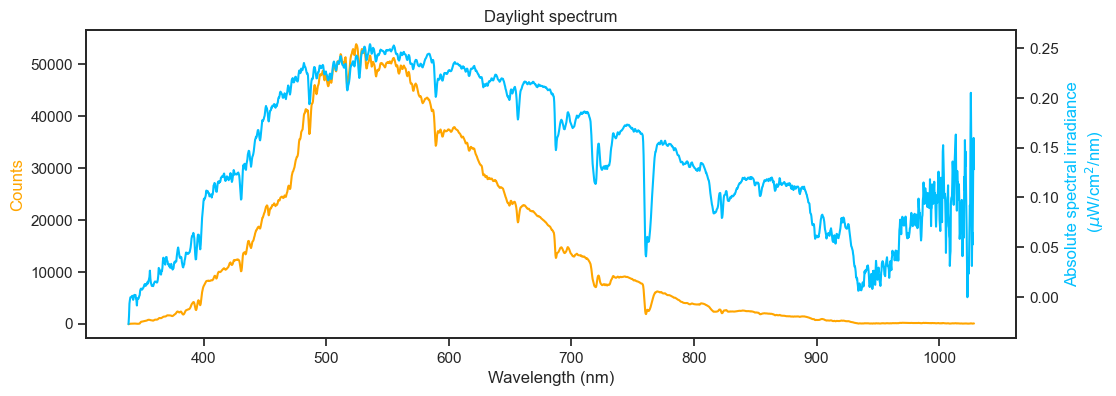

In [70]:
try:
    # Connect to spectrometer
    oo = oceanops.OceanOptics.from_serial_number('JAZA1505')
    
    # Obtain sample
    counts, info = oo.sample(
        correct_dark_counts=True,
        correct_nonlinearity=True,
        integration_time=None,  # Optimize integration time
        scans_to_average=3,  # Average of three scans
        box_car_width=3,  # Boxcar smoothing
        sample_id='daylight_spectrum'
    )
    
    # Absolute spectral irradiance
    irrad_spd = (
        (counts)  # Already corrected for dark counts
        * (calibration_file
           / (integration_time
              * collection_area
              * wavelength_spread)
          )
    )

    # Visualise
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(calibrated_wls, counts, c='orange', label='Counts')
    ax.set_ylabel('Counts', {'color':'orange'})
    ax.set_title('Daylight spectrum')
    ax.set_xlabel('Wavelength (nm)')
    twinx = ax.twinx()
    twinx.plot(calibrated_wls, irrad_spd, c='deepskyblue', label='Irradiance')
    twinx.set_ylabel('Absolute spectral irradiance\n ($\mu$W/cm$^2$/nm)', {'color':'deepskyblue'})

    
except KeyboardInterrupt:
    print('> Measurement terminated  by user')

finally:
    oo.close()